In [2]:
import sys
sys.path.append("..\\scripts\\")
import torch 
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import numpy as np
import matplotlib.pyplot as plt
from torch.func import vmap, grad
from tqdm import tqdm
from scipy.stats import binned_statistic_2d
import mpol.constants as const

plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 10
from score_models import ScoreModel, NCSNpp
import json

plt.style.use("dark_background")

from utils import fits_to_tensor, link_function
device = "cuda" if torch.cuda.is_available() else "cpu"

# Importing the models hparams and weights
file = open("../../ncsnpp_ct_g_220912024942/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

# Importing the weights
score_model = ScoreModel(checkpoints_directory="../../ncsnpp_ct_g_220912024942")

In [3]:
data = np.load("../../HTLup_continuum2.npz")

u = data["uu"]
v = data["vv"]
vis = data["data"]
weight = data["weight"]

uu = np.concatenate([u, u])
vv = np.concatenate([v, v])

vis_re = np.concatenate([vis.real, vis.real])
vis_imag = np.concatenate([vis.imag, vis.imag])
weight = np.concatenate([weight, weight])


In [8]:
d = (u[0]-u[1:]) ** 2 + (v[0] - v[1:])**2

In [ ]:
index_min = d.argmin()

In [19]:
indx = (vis[0] - vis[1:]).argmin()+ 1 

In [22]:
vis[indx-1]-vis[0]

(-0.007840988719357705+0.041016787674305256j)

In [18]:
vis[629]

(0.03516128651191374+0.02353564269645325j)

In [16]:
vis[0]-vis[629]

(0.01983368812461561-0.012430107369835913j)

In [9]:
d.argmin()

629

In [4]:
std = weight ** -0.5

(array([ 761478.,  967300., 1209064., 1481916., 1786162., 2098798.,
        2418126., 2723386., 2998802., 3228774., 3390080., 3488818.,
        3503838., 3447302., 3312888., 3118876., 2868952., 2584416.,
        2283060., 1973580.]),
 array([-0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
        -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,
         0.08,  0.09,  0.1 ]),
 <BarContainer object of 20 artists>)

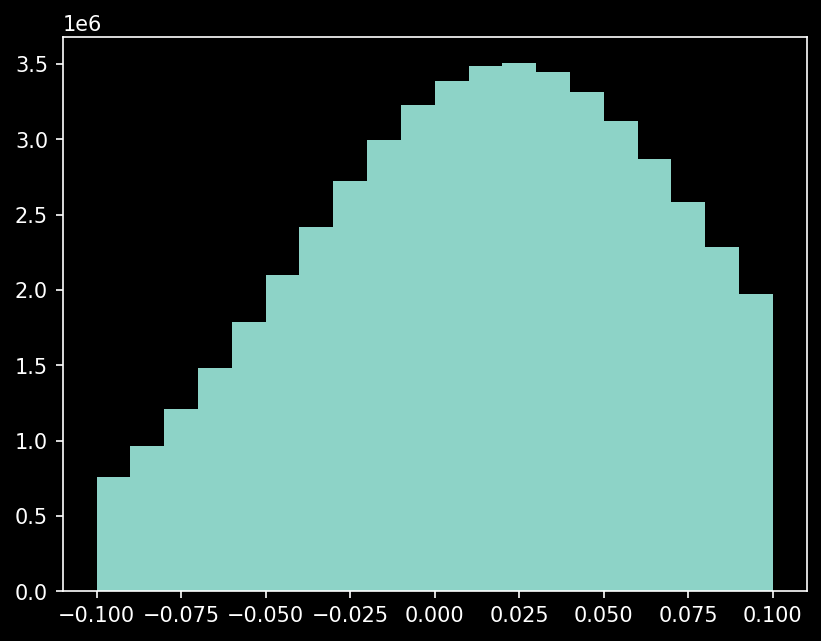

In [11]:
plt.hist(vis_re, bins = 20, range = [-0.1, 0.1])

(array([       0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,    45428.,  1752860., 21783980., 23889184.,  9514024.,
         1963180.,   437136.]),
 array([-0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
        -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,
         0.08,  0.09,  0.1 ]),
 <BarContainer object of 20 artists>)

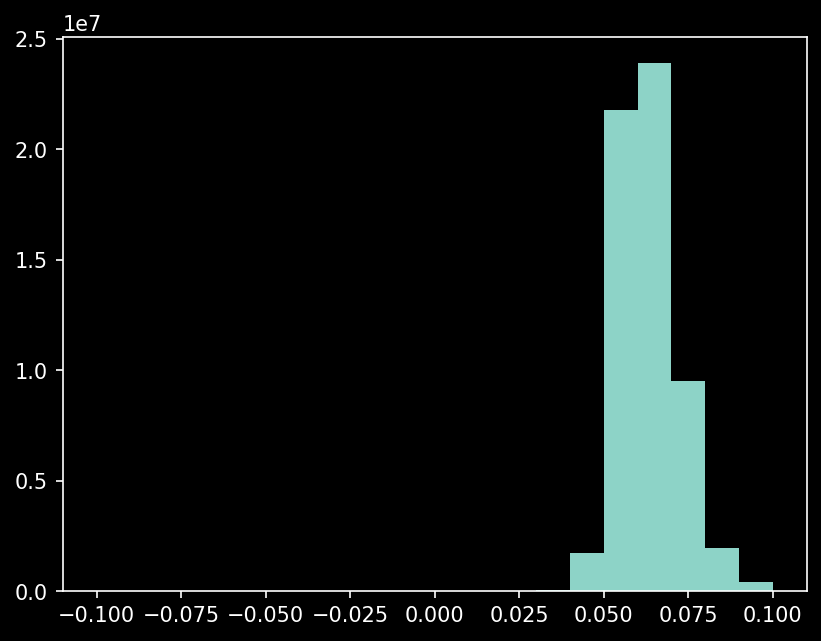

In [12]:
plt.hist(std, bins = 20, range = [-0.1, 0.1])

In [3]:
pixel_scale = 0.0015 # arcsec
npix = 256 # number of pixels in the final image

# Arcsec to radians: 
dl = pixel_scale * const.arcsec
dm = pixel_scale * const.arcsec

du = 1 / (npix * dl) * 1e-3 # klambda
dv = 1 / (npix * dm) * 1e-3 # klambda

u_min = -npix//2 * du 
u_max = npix//2 * du 

v_min = -npix//2 * dv
v_max = npix//2 * dv

u_edges = np.linspace(u_min, u_max, npix + 1)
v_edges = np.linspace(v_min, v_max, npix + 1)

Text(0, 0.5, 'v [k$\\lambda$]')

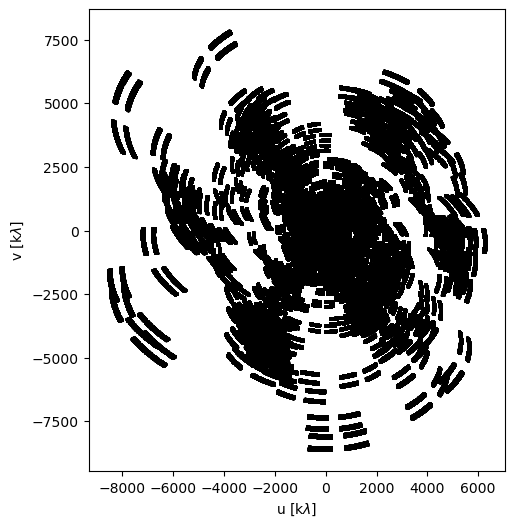

In [7]:
# Plotting the uv coverage: 
figure = plt.figure(figsize = (6, 6))
plt.scatter(u, v, s = 0.5, rasterized = True, color = "k") # Might take some time since there are a lot of uv points 

# for i in range(len(u_edges)): 
#     plt.axvline(u_edges[i])
#     plt.axhline(v_edges[i])

# plt.xlim([u.min(), u.max()])
# plt.ylim([v.min(), v.max()])
plt.gca().set_aspect("equal")
plt.xlabel(r"u [k$\lambda$]")
plt.ylabel(r"v [k$\lambda$]")

In [18]:
bin_x = u_edges
bin_y = v_edges
vis_gridded_re, edgex, edgey, binnumber = binned_statistic_2d(uu, vv, vis_re, "mean", (bin_x, bin_y))
vis_gridded_img, edgex, edgey, binnumber = binned_statistic_2d(uu, vv, vis_imag, "mean", (bin_x, bin_y))

std_gridded_re, edgex, edgey, binnumber = binned_statistic_2d(uu, vv, vis_re, "std", (bin_x, bin_y))
std_gridded_img, edgex, edgey, binnumber = binned_statistic_2d(uu, vv, vis_imag, "std", (bin_x, bin_y))

In [68]:
vis_gridded_re[np.isnan(vis_gridded_re)] = 0
vis_gridded_img[np.isnan(vis_gridded_img)] = 0

vis_gridded_re, vis_gridded_img = np.fft.fftshift(vis_gridded_re), np.fft.fftshift(vis_gridded_img)
std_gridded_re, std_gridded_img = np.fft.fftshift(std_gridded_re), np.fft.fftshift(std_gridded_img)
S_grid = vis_gridded_re.astype(bool)

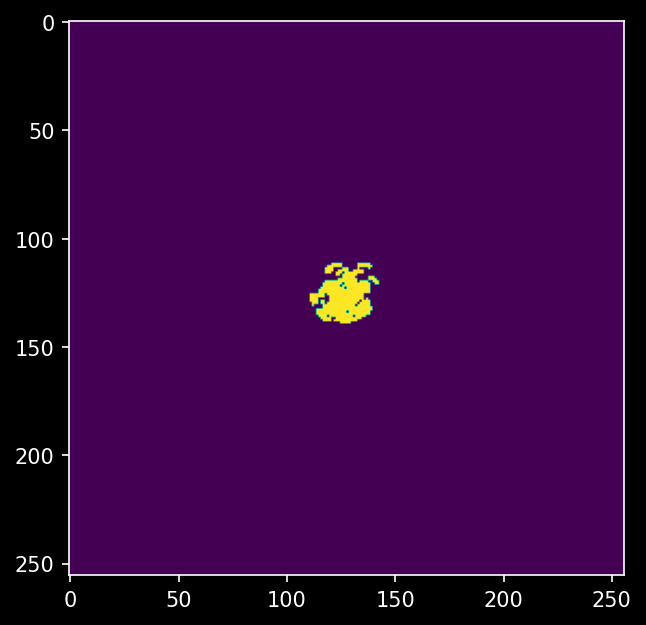

In [71]:
plt.imshow(np.fft.fftshift(S_grid))

In [77]:
img_size = npix

# Concatenate real and imaginary parts of the gridded visibilities and the sigma noise
vis_gridded = np.concatenate([vis_gridded_re.flatten(), vis_gridded_img.flatten()])
std_gridded = np.concatenate([std_gridded_re.flatten(), std_gridded_img.flatten()])
S = np.concatenate([S_grid.flatten(), S_grid.flatten()])

# numpy > torch
vis_gridded = torch.tensor(vis_gridded).to(device)
std_gridded = torch.tensor(std_gridded).to(device)
S = torch.tensor(S).to(device)

# Getting rid of all the cells without information
y = vis_gridded[S]*256
sigma_y = std_gridded[S] / 256**2

img_size = npix

In [78]:
def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")
    
def ift(x): 
    return torch.fft.ifft2(x, norm = "ortho")

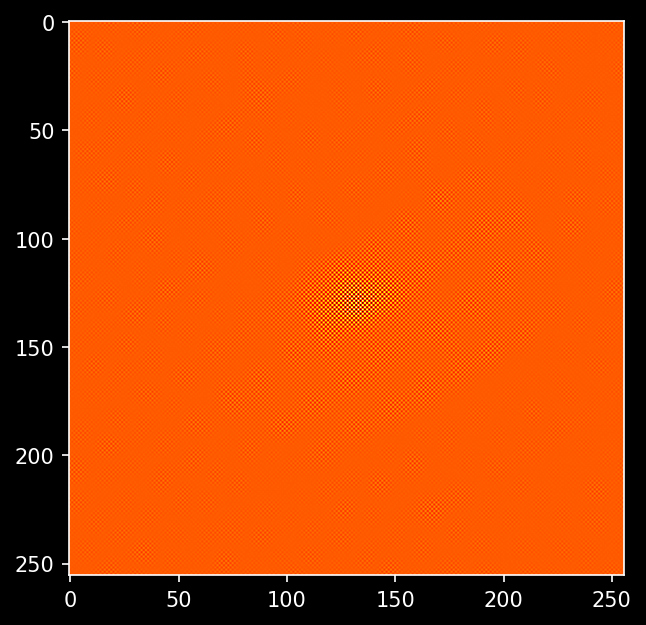

In [79]:
dirty_image = torch.tensor(vis_gridded_re + 1j * vis_gridded_img)
plt.imshow(torch.fft.fftshift(ift(torch.fft.fftshift(dirty_image))).real, cmap = "hot")

In [54]:
vis_gridded.mean()

tensor(1.0651e-05, device='cuda:0', dtype=torch.float64)

In [53]:
sigma_y.mean()

tensor(1.0243e-06, device='cuda:0', dtype=torch.float64)

In [80]:
#sigma_y = 1e-8 * torch.ones(D).to(device)
#beta = 0
def sigma(t): 
    return sigma_min * (sigma_max/sigma_min) ** t


def model(x):
    x = x.reshape(img_size, img_size) # for the FFT 
    x = link_function(x) # map from model unit space to real unit space

    # Padding: 
    #pad_size = int((npix - img_size)/2)
    #x = torch.nn.functional.pad(x, (pad_size, pad_size, pad_size, pad_size)) 
    vis_full = ft(x).flatten() 
    vis_sampled = torch.cat([vis_full.real, vis_full.imag])[S]
    return vis_sampled


def log_likelihood(y, x, t, sigma_y):
    """
    Calculate the log-likelihood of a gaussian distribution 
    Arguments: 
        y = processed gridded visibilities (real part and imaginary part concatenated)
        x = sky brightness 
        t = diffusion temperature
        A = linear model (sampling function and FT)  
    
    Returns: 
        log-likelihood of a gaussian distribution
    """ 
    y_hat = model(x)
    var = sigma(t) **2 / 2 + sigma_y**2
    log_prob = -0.5 * torch.sum((y - y_hat)**2 / var)
    return log_prob


# GIVE THE GOOD COVARIANCE MATRIX
def score_likelihood(x, t): 
    x = x.flatten(start_dim = 1) 
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y)))(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    x = x.reshape(-1, 1, img_size, img_size)
    return score_model.score(t, x).flatten(start_dim = 1) + score_likelihood(x, t)

x = torch.randn([1, img_size ** 2]).to(device) 
t = torch.ones([1]).to(device)

print((torch.sum(score_likelihood(x, t)**2))**0.5)
print(score_posterior(x, t))

tensor(0.0017, device='cuda:0')
tensor([[ 0.0046,  0.0008, -0.0020,  ..., -0.0011,  0.0069,  0.0016]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [81]:
def g(t): 
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
            
    return link_function(x_mean)

def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = sigma_max * torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return link_function(x_mean)

pred = 500
corr = 100
snr = 1e-2
samples = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = img_size)
#samples = pc_sampler(num_samples = 1, num_pred_steps = pred, num_corr_steps = corr, snr = snr, score_function = score_posterior, img_size = img_size)

100%|██████████| 499/499 [01:56<00:00,  4.28it/s]


True


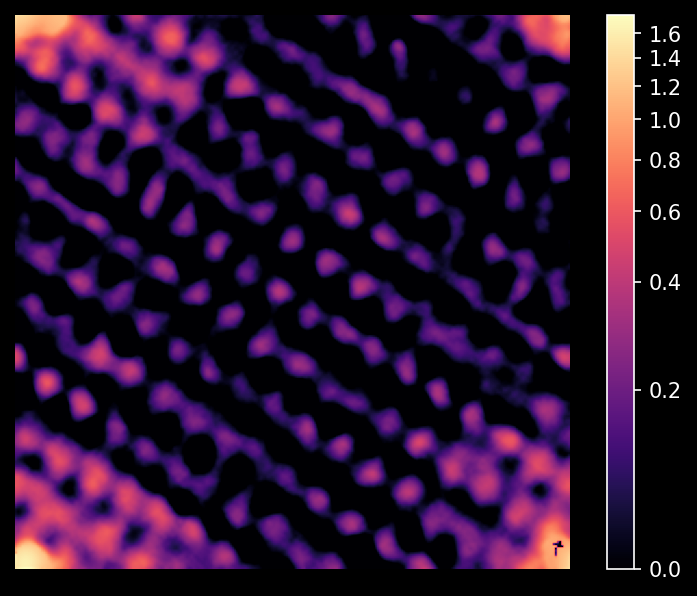

In [82]:
norm = True
save = False
n_images = len(samples)
grid_size = int(n_images**0.5)
if n_images != 1:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((samples[k]).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            #if k==0: 
                #plt.colorbar(im)
            k+=1
else: 
    print(norm)
    if norm:
        save_path = f"../../images/HTLup_pad{npix}norm.jpeg"
        norm = ImageNormalize(samples.cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    else: 
        save_path = f"../../images/HTLup_pad{npix}nonorm.jpeg"
        norm = None
    plt.imshow((samples).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
    plt.colorbar()
if save: 
    plt.savefig(save_path, bbox_inches = "tight", pad_inches = 0.1)